In [2]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor
import cv2

checkpoint= '/mnt/segment-anything-eo/sam_vit_h_4b8939.pth' #"/mnt/segment-anything-eo/sam_vit_h_4b8939.pth",
sam = sam_model_registry['vit_h'](checkpoint=checkpoint)
device = 'cuda:0'
sam.to(device)
mask_generator = SamAutomaticMaskGenerator(sam)

img = cv2.cvtColor(cv2.imread('/mnt/Mussel/Mussel.png'), cv2.COLOR_BGR2RGB)
masks = mask_generator.generate(img)

In [2]:
#Need input points to make this work

# from segment_anything import SamPredictor
# predictor = SamPredictor(sam)

# predictor.set_image(img)
# masks, _, _ = predictor.predict( 'Mussel', point_coords = None)

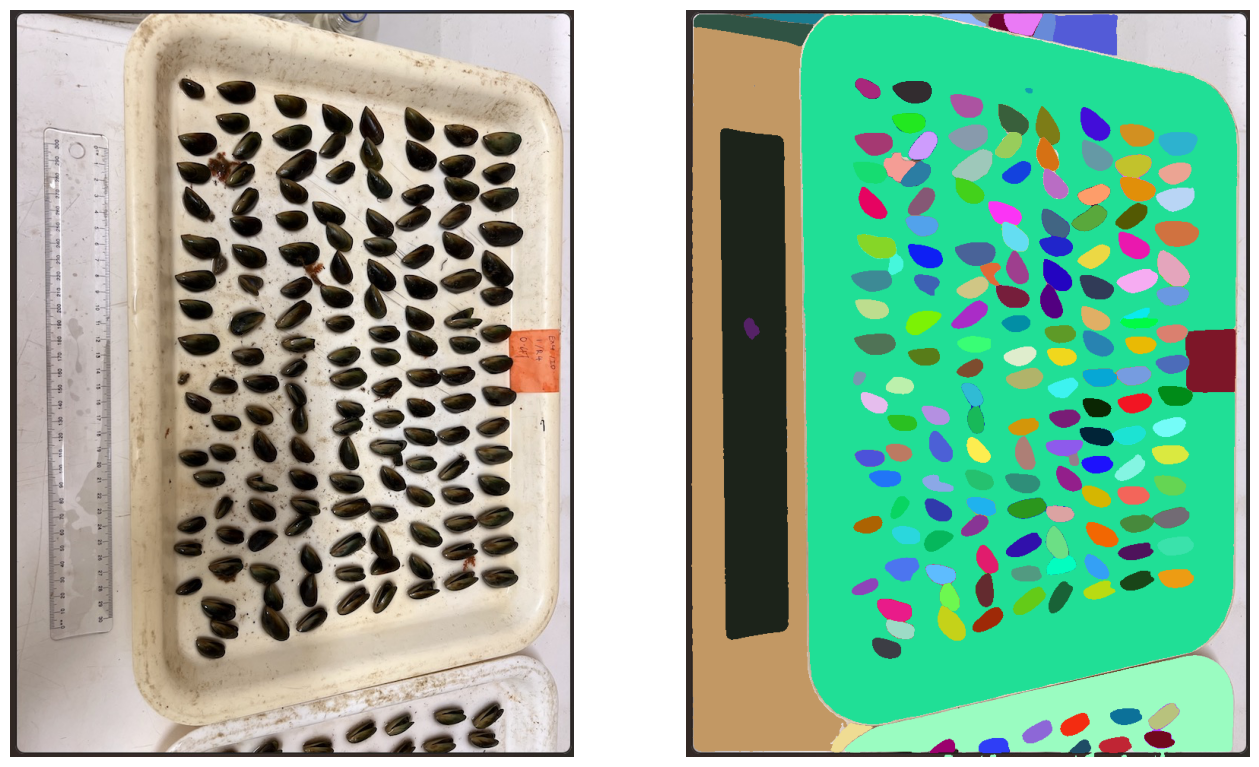

In [3]:
import random
import matplotlib.pyplot as plt
import numpy as np

def show_anns(anns, axes=None):
    if len(anns) == 0:
        return
    if axes:
        ax = axes
    else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m**0.5)))

# Plot the original image and the mask
fig, axs = plt.subplots(1, 2, figsize=(16, 16))
axs[0].imshow(img)
axs[1].imshow(img)
show_anns(masks, axs[1])
axs[0].axis('off')
axs[1].axis('off')
plt.savefig('/mnt/Mussel/Mussel_segments.png')
plt.show()
# for idx in random_indices:
#     # Get the image tensor
#     image_tensor= train_dataset[idx]

#     # Apply the mask generator
#     masks = mask_generator1.generate(image_tensor)

#     # Convert the image tensor back to a PIL image
#     image = torchvision.transforms.ToPILImage()(image_tensor)
    
#     # Plot the original image and the mask
#     fig, axs = plt.subplots(1, 2, figsize=(12, 4))
#     axs[0].imshow(image)
#     axs[1].imshow(image)
#     show_anns(masks, axs[len(image)][len(image[0])])
#     axs[0].axis('off')
#     axs[1].axis('off')
#     plt.show()

In [5]:
import matplotlib.pyplot as plt # Plotting
import numpy as np # Numeric data
import pandas as pd # Tabular data
from rasterio.features import shapes # Vectorising rasters to polygons
from shapely import Point, LineString # Geometry
from shapely.geometry import box, shape
import geopandas as gpd # Plotting polygons
from tqdm.auto import tqdm # Progress bars
tqdm.pandas()

def bbox_to_shape(bbox):
    x,y,w,h = bbox
    return box(x,y,x+w,y+h)

def mask_to_shape(mask):
    return gpd.GeoSeries(shape(s) for s,v in shapes(mask.astype(np.uint8), mask)).unary_union

mask_shapes = gpd.GeoSeries([mask_to_shape(m["segmentation"]) for m in tqdm(masks)])

print(mask_shapes)

df = gpd.GeoDataFrame(masks, geometry=mask_shapes)
df

  0%|          | 0/198 [00:00<?, ?it/s]

0      POLYGON ((49.000 157.000, 57.000 157.000, 57.0...
1      POLYGON ((708.000 421.000, 721.000 421.000, 72...
2      POLYGON ((289.000 95.000, 313.000 95.000, 313....
3      POLYGON ((471.000 329.000, 476.000 329.000, 47...
4      MULTIPOLYGON (((434.000 155.000, 431.000 155.0...
                             ...                        
193    MULTIPOLYGON (((594.000 192.000, 585.000 192.0...
194    POLYGON ((482.000 680.000, 486.000 680.000, 48...
195    POLYGON ((224.000 477.000, 232.000 477.000, 23...
196    POLYGON ((397.000 335.000, 410.000 335.000, 41...
197    POLYGON ((447.000 104.000, 454.000 104.000, 45...
Length: 198, dtype: geometry


,segmentation,area,bbox,predicted_iou,point_coords,stability_score,crop_box,geometry
0,"[[False, False, False, False, False, False, Fa...",55264,"[45, 157, 89, 672]",1.012357,"[[81.15625, 169.125]]",0.987980,"[0, 0, 742, 984]","POLYGON ((49.000 157.000, 57.000 157.000, 57.0..."
1,"[[False, False, False, False, False, False, Fa...",5215,"[657, 421, 65, 83]",1.006585,"[[660.84375, 476.625]]",0.988195,"[0, 0, 742, 984]","POLYGON ((708.000 421.000, 721.000 421.000, 72..."
2,"[[False, False, False, False, False, False, Fa...",1163,"[272, 95, 50, 28]",0.999485,"[[313.03125, 107.625]]",0.987201,"[0, 0, 742, 984]","POLYGON ((289.000 95.000, 313.000 95.000, 313...."
3,"[[False, False, False, False, False, False, Fa...",1081,"[470, 329, 37, 41]",0.998013,"[[475.34375, 353.625]]",0.992634,"[0, 0, 742, 984]","POLYGON ((471.000 329.000, 476.000 329.000, 47..."
4,"[[False, False, False, False, False, False, Fa...",473919,"[151, 8, 573, 932]",0.997716,"[[220.28125, 814.875]]",0.956580,"[0, 0, 742, 984]","MULTIPOLYGON (((434.000 155.000, 431.000 155.0..."
...,...,...,...,...,...,...,...,...
193,"[[False, False, False, False, False, False, Fa...",2232,"[565, 191, 52, 91]",0.899371,"[[568.09375, 199.875]]",0.960158,"[0, 0, 742, 984]","MULTIPOLYGON (((594.000 192.000, 585.000 192.0..."
194,"[[False, False, False, False, False, False, Fa...",1572,"[473, 680, 39, 63]",0.898811,"[[498.53125, 722.625]]",0.968652,"[0, 0, 742, 984]","POLYGON ((482.000 680.000, 486.000 680.000, 48..."
195,"[[False, False, False, False, False, False, Fa...",235,"[220, 477, 16, 17]",0.898391,"[[220.28125, 476.625]]",0.974684,"[0, 0, 742, 984]","POLYGON ((224.000 477.000, 232.000 477.000, 23..."
196,"[[False, False, False, False, False, False, Fa...",1432,"[388, 335, 63, 57]",0.892132,"[[428.96875, 384.375]]",0.963649,"[0, 0, 742, 984]","POLYGON ((397.000 335.000, 410.000 335.000, 41..."


In [47]:
mask = seg_mask
mask = np.array(mask)
mask = np.reshape(mask, (mask.shape[0], mask.shape[1], 1))
print(mask.shape)
# # # use thresholding
thresh, _, _ = cv2.threshold(mask, 0, 1, cv2.THRESH_BINARY)

(984, 742, 1)


error: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/thresh.cpp:1659: error: (-210:Unsupported format or combination of formats)  in function 'threshold'


In [41]:
mask = seg_mask

dist_C = cv2.distanceTransform(thresh, cv2.DIST_C, 3)

# # # use thresholding
thresh = cv2.threshold(mask, 0, 1, cv2.THRESH_BINARY)[1]

# # get distance transform
# distance = gray #thresh.copy()
# distance = cv2.distanceTransform(distance, distanceType=cv2.DIST_L2, maskSize=1).astype(np.float32)
# print(distance)

# # get skeleton (medial axis)
# binary = gray #thresh.copy()
# binary = binary.astype(np.float32)/255
# skeleton = skimage.morphology.skeletonize(binary).astype(np.float32)

# # apply skeleton to select center line of distance 
# thickness = cv2.multiply(distance, skeleton)

# # get average thickness for non-zero pixels
# average = np.mean(thickness[skeleton!=0])

# # thickness = 2*average
# thick = 2 * average
# print("thickness:", thick)

#     # contours, _ = cv2.findContours(seg_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
#     # print(contours)
#     # polygons = []

#     # for obj in contours:
#     #     coords = []
            
#     #     for point in obj:
#     #         coords.append(int(point[0][0]))
#     #         coords.append(int(point[0][1]))

#     #     polygons.append(coords)
#     # print(polygons)

error: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/thresh.cpp:1659: error: (-210:Unsupported format or combination of formats)  in function 'threshold'


In [4]:
# from shapely.geometry import Polygon

# for mask in masks:
#     #print(mask['bbox'])
#     bbox_points = mask['bbox']
#     segmentation_points = mask['segmentation']
#     segmented_polygon = Polygon(np.reshape(np.array(segmentation_points), (-1,2)))
#     print(segmented_polygon)
    # length = bbox_points[2] - bbox_points[0]
    # if length < 0:
    #     length = length * -1
    # width = bbox_points[3] - bbox_points[1]
    # if width < 0:
    #     width = width * -1
    # print(f"BBOX to length {length} and width {width} in pixels")
